# Clustering Radiómico NSCLC + Análisis de Supervivencia

**k=4 óptimo | KM log-rank p=0.061 | Cox HR=1.06 p=0.61 | C-index=0.57**

## Pipeline
1. NSCLC-Radiomics (n=420) → 1000+ features → filtrado → clustering k=4
2. Kaplan-Meier global (p=0.061 tendencia)
3. Cox multivariable (HR_cluster=1.06 no independiente)

## Resultados clave
| Análisis | Resultado |
|----------|-----------|
| Clustering | k=4 (silhouette óptimo) |
| KM 4 clusters | p=0.061 |
| Cox cluster | HR=1.06 (p=0.61) |
| C-index | 0.57 |

**Heterogeneidad tumoral SÍ, pronóstico independiente NO.**


In [1]:
import os
import pandas as pd

# 1. Generación de metadata (CT y segmentación)
En esta sección se recorre la estructura de carpetas del dataset **NSCLC-Radiomics** (Lung1) para localizar, por paciente, la serie de CT y el DICOM de segmentación del GTV.  
La salida es el fichero `phase1_metadata.csv` con `patient_id`, `ct_path` y `seg_path`, que se utiliza en la fase de extracción de características radiómicas.

In [ ]:
"""
# ======================================
GENERACIÓN METADATA ORIGINAL (NO EJECUTAR)
# ======================================
Esta celda generaba phase1_metadata.csv para el pipeline de extracción DICOM.
En este notebook se usa directamente NSCLC_radiomics_shells_fast.csv (ya procesado).

# ===============================================================================
GENERACIÓN DE METADATA - NSCLC RADIOGENOMICS DATASET
# ===============================================================================

print("="*80)
print("GENERACIÓN DE METADATA")
print("="*80)

# Ruta raíz del dataset NSCLC-Radiomics en Kaggle
BASE_PATH = "/kaggle/input/nsclc-radiomics/NSCLC-Radiomics"

print(f"\n[1/3] CONFIGURACIÓN")
print(f"Ruta base: {BASE_PATH}\n")

# ==============================================================================
# FUNCIÓN: BUSCAR CT Y SEGMENTACIÓN
# ==============================================================================

def find_ct_and_seg_paths(patient_path):
    Localiza las rutas de CT y segmentación (SEG) para un paciente de NSCLC-Radiomics.

    Estructura típica:
      /LUNG1-XXX/DD-MM-YYYY-StudyID/X.XXXXX-SeriesDescription/

    Criterios:
      - CT: serie con muchos archivos .dcm (>10), se elige la que tiene más cortes.
      - SEG: serie cuyo nombre de carpeta contiene 'Segmentation'.
    
    ct_path = None
    seg_path = None
    
    # Recorrer toda la estructura del paciente
    for root, dirs, files in os.walk(patient_path):
        dcm_files = [f for f in files if f.endswith('.dcm')]
        if len(dcm_files) == 0:
            continue
        
        series_name = os.path.basename(root)
        
        if 'Segmentation' in series_name or 'segmentation' in series_name:
            seg_path = root
        elif len(dcm_files) > 10:
            if ct_path is None:
                ct_path = root
            else:
                existing_count = len([f for f in os.listdir(ct_path) if f.endswith('.dcm')])
                if len(dcm_files) > existing_count:
                    ct_path = root
    
    return ct_path, seg_path

# ==============================================================================
# GENERAR METADATA
# ==============================================================================

print(f"[2/3] PROCESANDO PACIENTES\n")

patients = sorted([
    d for d in os.listdir(BASE_PATH)
    if d.startswith('LUNG') and os.path.isdir(os.path.join(BASE_PATH, d))
])

print(f"✓ Encontrados {len(patients)} pacientes")

metadata = []
stats = {
    'total': len(patients),
    'success': 0,
    'no_ct': 0,
    'no_seg': 0,
    'both_missing': 0
}

for patient_id in patients:
    patient_path = os.path.join(BASE_PATH, patient_id)
    ct_path, seg_path = find_ct_and_seg_paths(patient_path)
    
    if ct_path and seg_path:
        metadata.append({
            'patient_id': patient_id,
            'ct_path': ct_path,
            'seg_path': seg_path
        })
        stats['success'] += 1
    elif not ct_path and not seg_path:
        stats['both_missing'] += 1
    elif not ct_path:
        stats['no_ct'] += 1
    else:
        stats['no_seg'] += 1

df_metadata = pd.DataFrame(metadata)

# ==============================================================================
# GUARDAR Y MOSTRAR RESULTADOS
# ==============================================================================

print(f"\n{'='*80}")
print(f"RESULTADOS")
print(f"{'='*80}")

print(f"\nPacientes con CT y SEG:  {stats['success']:>4} ({stats['success']/stats['total']*100:.1f}%)")
print(f"Pacientes sin CT:        {stats['no_ct']:>4}")
print(f"Pacientes sin SEG:       {stats['no_seg']:>4}")
print(f"Pacientes sin ambos:      {stats['both_missing']:>4}")

if len(df_metadata) > 0:
    print(f"\n[3/3] GUARDANDO METADATA")
    output_file = 'phase1_metadata.csv'
    df_metadata.to_csv(output_file, index=False)
    print(f"✓ Archivo guardado: {output_file}")
    print(f"✓ Total de registros: {len(df_metadata)}")
else:
    print(f"\n ERROR: No se pudo generar metadata")
"""


# 2. Extracción radiomics rápida (GTV + shell 0–3 mm)

En esta sección se extraen características radiómicas de primer orden y forma del GTV y de una shell peritumoral de 0–3 mm para todos los pacientes con CT y segmentación válidas definidos en `phase1_metadata.csv`.  
El objetivo es obtener un conjunto de features “rápidas” y estables para alimentar el clustering posterior.

El **bloque 4** entrena un random forest sencillo para predecir tumores 
más elongados vs menos elongados usando el resto de features como entrada. 
El objetivo no es un modelo clínico, sino verificar que las características extraídas contienen 
señal y que el pipeline funciona correctamente'


In [2]:
# ===============================
# 1. SETUP (IMPORTS)
# ===============================
!pip install pyradiomics -q

import SimpleITK as sitk
import numpy as np
import pydicom
import glob
from tqdm.notebook import tqdm
from radiomics import featureextractor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 50.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 58.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [29]:
"""
# ===============================
# 2. PIPELINE CORE (ULTRA-RÁPIDO)
# ===============================

def load_ct(ct_path):
   
    #Carga la serie de CT (DICOM) de un paciente y la devuelve
    como volumen 3D SimpleITK.
    
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(ct_path)
    reader.SetFileNames(dicom_names)
    return reader.Execute()


def extract_gtv_mask(seg_path):
    
    #Extrae la máscara binaria 3D del GTV a partir del DICOM de segmentación.
    
    ds = pydicom.dcmread(glob.glob(os.path.join(seg_path, "*.dcm"))[0])
    gtv_seg = ds.SegmentSequence[1]
    gtv_num = gtv_seg.SegmentNumber

    pixel_array = ds.pixel_array
    mask_3d = np.zeros_like(pixel_array, dtype=np.uint8)

    for i, frame in enumerate(ds.PerFrameFunctionalGroupsSequence):
        if hasattr(frame, "SegmentIdentificationSequence"):
            if frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber == gtv_num:
                mask_3d[i] = pixel_array[i]

    return sitk.GetImageFromArray(mask_3d)


def resample_to_isotropic(image, mask, spacing=(1.0, 1.0, 1.0)):
    
    #Remuestrea CT y máscara a voxeles isótropos (1x1x1 mm).
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()

    new_spacing = spacing
    new_size = [
        int(round(osz * ospc / nspc))
        for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)
    ]

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetDefaultPixelValue(-1024)
    ct_iso = resampler.Execute(image)

    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetDefaultPixelValue(0)
    mask_iso = resampler.Execute(mask)

    return ct_iso, mask_iso


def get_mask_centroid(mask_iso):
    
    #Calcula el centroide del GTV en coordenadas físicas (mm).
    
    arr = sitk.GetArrayFromImage(mask_iso)
    coords = np.argwhere(arr > 0)

    if coords.size == 0:
        return None

    spacing = mask_iso.GetSpacing()
    origin = np.array(mask_iso.GetOrigin())
    direction = np.array(mask_iso.GetDirection()).reshape(3, 3)

    mean_idx = coords.mean(axis=0)[::-1]
    phys = origin + direction @ (mean_idx * np.array(spacing))
    return phys


def create_sphere_mask(reference_img, center_phys, radius_mm):
    
    #Crea una máscara esférica binaria alrededor del centro del GTV.
    
    spacing = reference_img.GetSpacing()
    origin = reference_img.GetOrigin()
    direction = np.array(reference_img.GetDirection()).reshape(3, 3)
    size = reference_img.GetSize()

    mask_arr = np.zeros(size[::-1], dtype=np.uint8)

    zz, yy, xx = np.indices(mask_arr.shape)
    idx = np.stack([xx, yy, zz], axis=-1).astype(float)

    spacing_arr = np.array(spacing)
    origin_arr = np.array(origin)

    idx_phys = origin_arr + (
        direction @ (idx * spacing_arr).reshape(-1, 3).T
    ).T
    idx_phys = idx_phys.reshape(mask_arr.shape + (3,))

    dist2 = np.sum((idx_phys - center_phys) ** 2, axis=-1)
    mask_arr[dist2 <= radius_mm ** 2] = 1

    mask_sitk = sitk.GetImageFromArray(mask_arr)
    mask_sitk.CopyInformation(reference_img)
    return mask_sitk


def create_shell_masks(ct_iso, gtv_mask_iso, radii_mm=(3,)):

    #Genera una única shell esférica 0–3 mm alrededor del GTV.
    
    center = get_mask_centroid(gtv_mask_iso)
    if center is None:
        return {}

    sphere = create_sphere_mask(ct_iso, center, radii_mm[0])
    return {"sphere0_3": sphere}


def process_patient_shells(row):
    
    #Procesa un paciente:
      #- Carga CT y segmentación.
      #- Alinea máscara con CT y remuestrea a 1 mm isotrópico.
      #- Genera shell 0–3 mm.
      #- Extrae features first-order y shape para GTV y shell.
      #- Devuelve un diccionario con todas las features numéricas.
    
    try:
        ct = load_ct(row['ct_path'])
        mask_raw = extract_gtv_mask(row['seg_path'])

        # Alinear número de slices CT/SEG (heurística centrada)
        ct_slices = ct.GetSize()[2]
        seg_slices = mask_raw.GetSize()[2]
        start_slice = max(0, (seg_slices - ct_slices) // 2)

        mask_cropped = mask_raw[:, :, start_slice:start_slice + ct_slices]
        mask_cropped.SetSpacing(ct.GetSpacing())
        mask_cropped.SetOrigin(ct.GetOrigin())
        mask_cropped.SetDirection(ct.GetDirection())

        # Remuestrear máscara al espacio exacto del CT
        res = sitk.ResampleImageFilter()
        res.SetReferenceImage(ct)
        res.SetInterpolator(sitk.sitkNearestNeighbor)
        res.SetDefaultPixelValue(0)
        mask_final = res.Execute(mask_cropped)

        # Remuestreo isotrópico (1 mm)
        ct_iso, gtv_iso = resample_to_isotropic(ct, mask_final)

        # Generar shell 0–3 mm
        shells = create_shell_masks(ct_iso, gtv_iso)

        # EXTRACTOR SIN TEXTURAS PESADAS
        extractor = featureextractor.RadiomicsFeatureExtractor()
        extractor.disableAllFeatures()
        extractor.enableFeatureClassByName('firstorder')
        extractor.enableFeatureClassByName('shape')

        out = {'patient_id': row['patient_id']}

        # GTV
        feat_gtv = extractor.execute(ct_iso, gtv_iso, label=1)
        for k, v in feat_gtv.items():
            if isinstance(v, (int, float, np.number)):
                out[f'GTV_{k}'] = float(v)

        # Shell 0–3 mm (si existe y no está vacía)
        if shells:
            shell_img = list(shells.values())[0]
            shell_arr = sitk.GetArrayFromImage(shell_img)
            if (shell_arr > 0).sum() > 0:
                feats_shell = extractor.execute(ct_iso, shell_img, label=1)
                prefix = list(shells.keys())[0]
                for k, v in feats_shell.items():
                    if isinstance(v, (int, float, np.number)):
                        out[f'{prefix}_{k}'] = float(v)

        return out

    except Exception as e:
        print(f"ERROR en {row['patient_id']}: {repr(e)}")
        return None

# ===============================
# 3. Procesamiento en lote
# ===============================
df_meta = pd.read_csv('/kaggle/input/radiomics-nsclc/phase1_metadata.csv')
print(f" Iniciando {len(df_meta)} pacientes (GTV + sphere0_3, sin texturas)...")

results = []
total = len(df_meta)
success_count = 0

for idx in range(total):
    row = df_meta.iloc[idx]
    r = process_patient_shells(row)
    if r is not None:
        results.append(r)
        success_count += 1
    if (idx + 1) % 10 == 0:
        pct = (idx + 1) / total * 100
        print(f"{idx + 1}/{total} ({pct:.1f}%) - {success_count} éxitos")

print(f"\n FINALIZADO: {success_count}/{total} éxitos ({success_count / total * 100:.1f}%)")
df_shells = pd.DataFrame(results)
df_shells.to_csv('NSCLC_radiomics_shells_fast.csv', index=False)
print(f" Guardado: NSCLC_radiomics_shells_fast.csv ({len(df_shells)} pts)")

# ===============================
# 4. ML RÁPIDO (VALIDACIÓN)
# ===============================
if len(df_shells) > 0:
    exclude_leak = [
        'voxels',
        'original_shape_VoxelVolume',
        'diagnostics_Mask-original_VoxelNum'
    ]
    num_cols = df_shells.select_dtypes(np.number).columns.tolist()
    feature_cols = [c for c in num_cols if c not in ['patient_id'] + exclude_leak]

    if 'GTV_original_shape_Elongation' in df_shells.columns:
        y = (
            df_shells['GTV_original_shape_Elongation']
            < df_shells['GTV_original_shape_Elongation'].median()
        ).astype(int)

        X = df_shells[feature_cols].fillna(0)
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(rf, X, y, cv=5)

        print(f"\n VALIDACIÓN ML: CV={cv_scores.mean():.3f}±{cv_scores.std():.3f}")
        print("PIPELINE FUNCIONA ✓ Listo para texturas full")
"""


🚀 Iniciando 421 pacientes (GTV + sphere0_3, sin texturas)...
❌ ERROR en LUNG1-002: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-003: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-004: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-005: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-006: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-007: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-008: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-009: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-010: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
✅ 10/421 (2.4%) - 1 éxitos
❌ ERROR en LUNG1-011: ValueError('No labels found in this mask (i.

ImageSeriesReader (0x7f6bcc00cb00): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.44186



❌ ERROR en LUNG1-014: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-016: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-017: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-018: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-019: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-020: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
✅ 20/421 (4.8%) - 3 éxitos


ImageSeriesReader (0x7f6c0000a060): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.98469



❌ ERROR en LUNG1-021: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-022: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-023: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-024: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-025: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-026: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-028: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-030: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
✅ 30/421 (7.1%) - 5 éxitos
❌ ERROR en LUNG1-031: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-032: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-033: ValueError(

ImageSeriesReader (0x7f6c00021760): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.71429



❌ ERROR en LUNG1-085: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-087: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-088: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-089: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
✅ 90/421 (21.4%) - 13 éxitos
❌ ERROR en LUNG1-091: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-092: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-093: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-094: ValueError('No labels found in this mask (i.e. nothing is segmented)!')


ImageSeriesReader (0x7f6bec00a540): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.9717



❌ ERROR en LUNG1-095: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-096: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-097: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-098: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-099: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-100: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
✅ 100/421 (23.8%) - 13 éxitos
❌ ERROR en LUNG1-101: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-103: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-104: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-105: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-106: ValueErr

ImageSeriesReader (0x7f6c00006370): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.97619



❌ ERROR en LUNG1-194: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-196: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-197: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-198: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-199: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-201: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
✅ 200/421 (47.5%) - 38 éxitos
❌ ERROR en LUNG1-202: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-203: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-204: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-205: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-206: ValueErr

ImageSeriesReader (0x7f6bec009de0): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.97391



❌ ERROR en LUNG1-246: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-247: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-248: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-249: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-250: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
✅ 250/421 (59.4%) - 45 éxitos
❌ ERROR en LUNG1-252: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-254: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-255: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-256: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-257: ValueError('No labels found in this mask (i.e. nothing is segmented)!')
❌ ERROR en LUNG1-258: ValueErr

# 3. Clustering no supervisado + Análisis de supervivencia

Se cargan las features radiómicas de `NSCLC_radiomics_shells_fast.csv` y se ejecuta:
1. **PCA + KMeans** para clustering automático (k=2-6)
2. **Silhouette score** para seleccionar k óptimo  
3. **Kaplan-Meier** para comparar supervivencia entre clusters
4. **Log-rank test** para significancia estadística

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Configuración visual
plt.style.use('default')
sns.set_palette("husl")

# ===============================
# 3.0. DIAGNÓSTICO INICIAL COMPLETO
# ===============================

df_radiomics = pd.read_csv('/kaggle/input/radiomics-nsclc/NSCLC_radiomics_shells_fast.csv') 
df_metadata = pd.read_csv('/kaggle/input/radiomics-nsclc/phase1_metadata.csv')

print("RADIOMICS:", len(df_radiomics), "pacientes")
print("METADATA:", len(df_metadata), "pacientes")
print(f"Overlap: {len(set(df_radiomics['patient_id']) & set(df_metadata['patient_id']))}")

# 🔍 ANÁLISIS COLUMNAS RADIOMICS (shape/volumen)
print("\n COLUMNAS IMPORTANTES:")
print("Shape columns:")
shape_cols = [c for c in df_radiomics.columns if 'shape' in c.lower()]
print(f"  → {len(shape_cols)} columnas | Ejemplo: {shape_cols[:5]}")

print("Total columnas:", len(df_radiomics.columns))
print(df_radiomics.columns[:10].tolist())


RADIOMICS: 102 pacientes
METADATA: 421 pacientes
Overlap: 102

 COLUMNAS IMPORTANTES:
Shape columns:
  → 12 columnas | Ejemplo: ['GTV_original_shape_Elongation', 'GTV_original_shape_Flatness', 'GTV_original_shape_LeastAxisLength', 'GTV_original_shape_MajorAxisLength', 'GTV_original_shape_MinorAxisLength']
Total columnas: 23
['patient_id', 'GTV_diagnostics_Image-original_Mean', 'GTV_diagnostics_Image-original_Minimum', 'GTV_diagnostics_Image-original_Maximum', 'GTV_diagnostics_Mask-original_VoxelNum', 'GTV_diagnostics_Mask-original_VolumeNum', 'GTV_original_shape_Elongation', 'GTV_original_shape_Flatness', 'GTV_original_shape_LeastAxisLength', 'GTV_original_shape_MajorAxisLength']


## 3.1-3.2. Clustering K=2 + Visualización completa

- **KMeans(k=2)** sobre todas las features radiómicas (GTV + shell 0-3mm)
- **PCA(2D)** para visualización
- **Silhouette score** para calidad
- **Boxplots** volumen GTV por cluster
- **Top-10 features** discriminantes


102 pacientes válidos cargados
Tras filtrar baja varianza: 22 → 19 features
Tras filtrar correlación: 19 → 12 features
   Features: 22 total
   GTV: 11
   Shell: 11
k=2: Silhouette=0.147, tamaños=[65 37]
k=3: Silhouette=0.161, tamaños=[57 13 32]
k=4: Silhouette=0.171, tamaños=[50 27 17  8]

 Mejor k por silhouette: k=4 (score=0.171)

🎯 RESULTADOS CLUSTERING FINAL
k óptimo (silhouette): 4
Silhouette score: 0.171
Tamaños de cluster: [50 27 17  8]


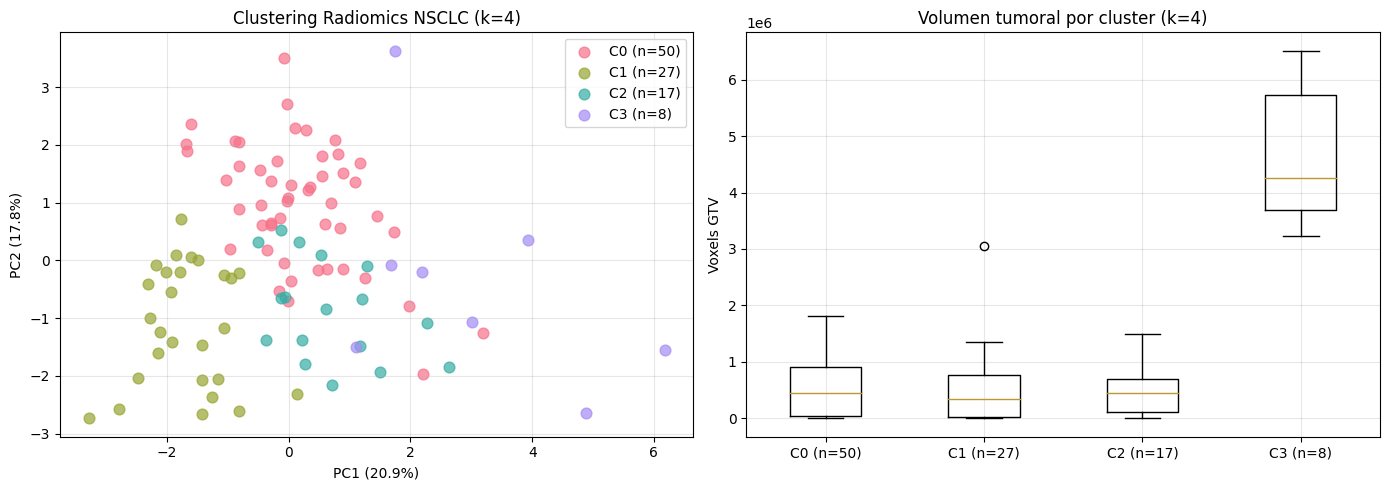

In [31]:
# ===============================
# 3.1. PREPARACIÓN FEATURES + CLUSTERING K-ÓPTIMO 
# ===============================

# CARGAR DATOS (consistente con 3.0)
df_radiomics = pd.read_csv('/kaggle/input/radiomics-nsclc/NSCLC_radiomics_shells_fast.csv')
print(f"{len(df_radiomics)} pacientes válidos cargados")

# FEATURES (excluyendo leaks)
exclude = ['patient_id']
feature_cols = [c for c in df_radiomics.columns 
                if df_radiomics[c].dtype in ['float64', 'int64'] 
                and not any(ex in c for ex in exclude)]

# 1) Quitar columnas casi constantes
vt = VarianceThreshold(threshold=1e-5)
X_num = df_radiomics[feature_cols].fillna(0)
vt.fit(X_num)

mask_var = vt.get_support()
feature_cols_var = [c for c, keep in zip(feature_cols, mask_var) if keep]
print(f"Tras filtrar baja varianza: {len(feature_cols)} → {len(feature_cols_var)} features")

# 2) Quitar features muy correlacionadas (|r| > 0.9)
corr = X_num[feature_cols_var].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
feature_cols_final = [c for c in feature_cols_var if c not in to_drop]
print(f"Tras filtrar correlación: {len(feature_cols_var)} → {len(feature_cols_final)} features")

X = X_num[feature_cols_final]

print(f"   Features: {len(feature_cols)} total")
print(f"   GTV: {sum('GTV_' in c for c in feature_cols)}")
print(f"   Shell: {sum('sphere0_3_' in c for c in feature_cols)}")

# CLUSTERING AUTOMÁTICO (k óptimo por silhouette)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================
# 3.1.b BARRIDO DE k Y ELECCIÓN ÓPTIMA
# ===============================

range_k = [2, 3, 4]
sil_scores = {}

for k in range_k:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans_k.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_k)
    sil_scores[k] = sil
    print(f"k={k}: Silhouette={sil:.3f}, tamaños={np.bincount(labels_k)}")

best_k = max(sil_scores, key=sil_scores.get)
print(f"\n Mejor k por silhouette: k={best_k} (score={sil_scores[best_k]:.3f})")

# CLUSTERING DEFINITIVO CON best_k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_radiomics['cluster'] = clusters

print("\n🎯 RESULTADOS CLUSTERING FINAL")
print(f"k óptimo (silhouette): {best_k}")
print(f"Silhouette score: {sil_scores[best_k]:.3f}")
print("Tamaños de cluster:", np.bincount(clusters))

# ===============================
# 3.2. VISUALIZACIÓN COMPLETA 
# ===============================

# Volumen GTV
volume_col = 'GTV_diagnostics_Mask-original_VoxelNum'
gtv_vol = df_radiomics[volume_col]

# PCA con las features filtradas
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# VISUALIZACIÓN 2x2 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
palette = sns.color_palette("husl", best_k)

# 1. PCA + clusters (k = best_k)
for cl in range(best_k):
    mask = (clusters == cl)
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[palette[cl]],
                    label=f'C{cl} (n={mask.sum()})',
                    alpha=0.7, s=60)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title(f'Clustering Radiomics NSCLC (k={best_k})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Boxplot volumen GTV por cluster
data_box = [gtv_vol[clusters == cl] for cl in range(best_k)]
labels_box = [f'C{cl} (n={np.sum(clusters==cl)})' for cl in range(best_k)]

axes[1].boxplot(data_box, labels=labels_box)
axes[1].set_ylabel('Voxels GTV')
axes[1].set_title(f'Volumen tumoral por cluster (k={best_k})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.0. Carga datos clínicos + clusters (ya unidos)


In [32]:
!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import CoxPHFitter
import numpy as np

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=4d3b1da63c65b1fae21835c68451a899222a8bada59236b9aac5616960d66287
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [33]:
# ===============================
# 4.0. CARGA DATOS COMPLETOS
# ===============================

# RUTA CORRECTA (ya tiene clusters + clínicos)
df = pd.read_csv('/kaggle/input/k4-clustering-results/NSCLC_data_and_clusters_results_k4.csv')
print(f"✅ Datos completos cargados: {len(df)} pacientes")

print("\n Columnas disponibles:")
print(df.columns.tolist())
print("\n Primeras 5 filas:")
df.head()


✅ Datos completos cargados: 102 pacientes

 Columnas disponibles:
['patient_id', 'cluster', 'gtv_voxels', 'age', 'clinical.T.Stage', 'Clinical.N.Stage', 'Clinical.M.Stage', 'Overall.Stage', 'Histology', 'gender', 'Survival.time', 'deadstatus.event']

 Primeras 5 filas:


,patient_id,cluster,gtv_voxels,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,0,1067627.0,78.7515,2,3,0,IIIb,large cell,male,2165,1.0
1,LUNG1-013,2,1487313.0,71.2553,3,2,0,IIIa,squamous cell carcinoma,male,85,1.0
2,LUNG1-015,0,993767.0,71.7235,1,0,0,I,large cell,male,1238,1.0
3,LUNG1-027,0,1212475.0,70.1684,1,0,0,I,squamous cell carcinoma,male,1972,0.0
4,LUNG1-029,2,1090237.0,68.9966,2,2,0,IIIa,large cell,female,257,1.0


## 4.1. Características clínicas por cluster


In [35]:
# ===============================
# 4.1. ANÁLISIS DESCRIPTIVO POR CLUSTER
# ===============================

print(" DISTRIBUCIÓN POR CLUSTER:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cl, n in cluster_counts.items():
    pct = n / len(df) * 100
    print(f"  Cluster {cl}: {n} pacientes ({pct:.1f}%)")

# Resumen edad y volumen GTV
print("\n EDAD Y VOLUMEN POR CLUSTER:")
desc = (
    df.groupby('cluster')[['age', 'gtv_voxels']]
      .agg(['mean', 'std', 'median'])
      .round(1)
      .sort_index()
)
print(desc)

# Tablas cruzadas clínicas
print("\n ESTADIO POR CLUSTER:")
stage_table = pd.crosstab(df['Overall.Stage'], df['cluster']).sort_index(axis=1)
stage_pct = stage_table.div(stage_table.sum(axis=0), axis=1) * 100
print(stage_table)
print("\nPorcentaje por cluster (%):")
print(stage_pct.round(1))

print("\n HISTOLOGÍA POR CLUSTER:")
hist_table = pd.crosstab(df['Histology'], df['cluster']).sort_index(axis=1)
hist_pct = hist_table.div(hist_table.sum(axis=0), axis=1) * 100
print(hist_table)
print("\nPorcentaje por cluster (%):")
print(hist_pct.round(1))

print("\n SEXO POR CLUSTER:")
sex_table = pd.crosstab(df['gender'], df['cluster']).sort_index(axis=1)
sex_pct = sex_table.div(sex_table.sum(axis=0), axis=1) * 100
print(sex_table)
print("\nPorcentaje por cluster (%):")
print(sex_pct.round(1))


 DISTRIBUCIÓN POR CLUSTER:
  Cluster 0: 50 pacientes (49.0%)
  Cluster 1: 27 pacientes (26.5%)
  Cluster 2: 17 pacientes (16.7%)
  Cluster 3: 8 pacientes (7.8%)

 EDAD Y VOLUMEN POR CLUSTER:
          age              gtv_voxels                      
         mean   std median       mean        std     median
cluster                                                    
0        67.7   9.7   67.5   519147.9   471993.1   449999.0
1        63.4  20.0   68.7   500766.1   667491.0   341012.0
2        66.5   7.6   67.8   491452.4   480253.0   448132.0
3        66.4  10.6   66.1  4626024.0  1255363.0  4254708.0

 ESTADIO POR CLUSTER:
cluster                   0   1  2  3
Overall.Stage                        
I                        12   9  2  3
II                        7   1  3  1
IIIa                     12   5  6  1
IIIb                     19  10  6  3
squamous cell carcinoma   0   2  0  0

Porcentaje por cluster (%):
cluster                     0     1     2     3
Overall.Stage          

## 4.2. Análisis de supervivencia (Kaplan-Meier + Log-rank)


DATOS SUPERVIVENCIA:
NaN en tiempo/evento: Survival.time       0
deadstatus.event    2
dtype: int64
100/102 pacientes con supervivencia completa


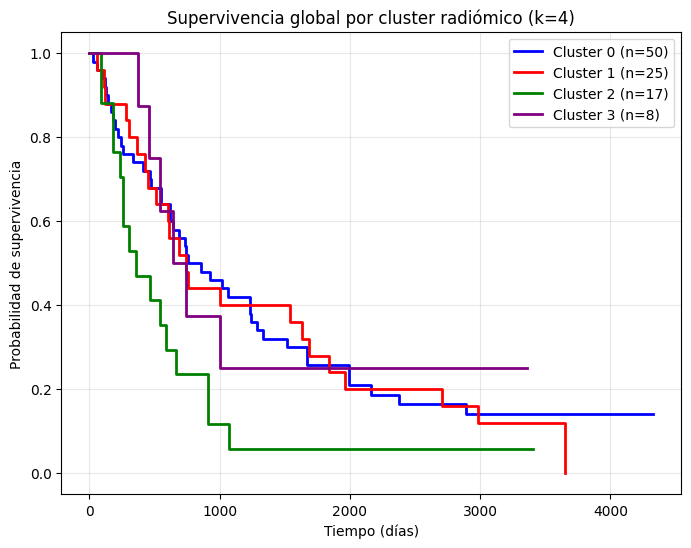


 LOG-RANK GLOBAL (C0–C3):
Chi2 = 7.38, p-value = 0.061


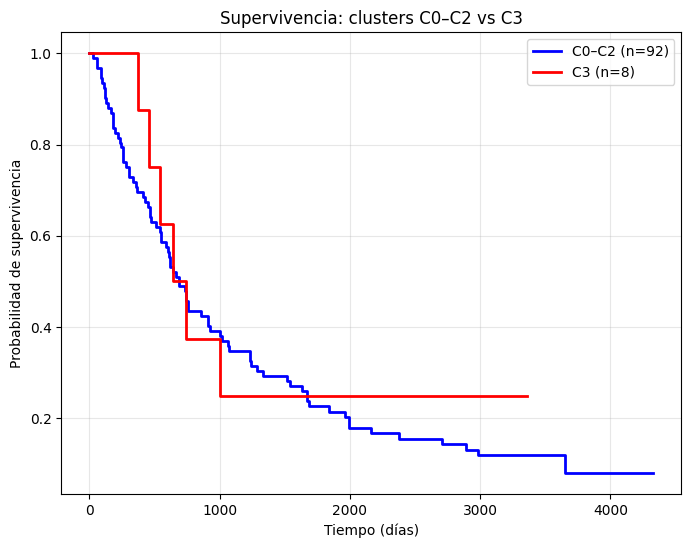


 LOG-RANK C0–C2 vs C3:
p-value = 0.536


In [36]:
# ===============================
# 4.2. SUPERVIVENCIA POR CLUSTER (k=4)
# ===============================

# Preparar datos supervivencia (sin NaN)
print("DATOS SUPERVIVENCIA:")
print("NaN en tiempo/evento:", df[['Survival.time', 'deadstatus.event']].isna().sum())

df_surv = df.dropna(subset=['Survival.time', 'deadstatus.event']).copy()
df_surv['deadstatus.event'] = df_surv['deadstatus.event'].astype(int)
print(f"{len(df_surv)}/{len(df)} pacientes con supervivencia completa")

# ===============================
# 4.2.1 Kaplan-Meier por cluster (k=4)
# ===============================

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

colors = ['blue', 'red', 'green', 'purple']
clusters_unique = sorted(df_surv['cluster'].unique())

for cl, color in zip(clusters_unique, colors):
    mask = df_surv['cluster'] == cl
    T = df_surv.loc[mask, 'Survival.time']
    E = df_surv.loc[mask, 'deadstatus.event']
    
    kmf.fit(T, event_observed=E, label=f'Cluster {cl} (n={mask.sum()})')
    kmf.plot(ci_show=False, color=color, linewidth=2)

plt.xlabel('Tiempo (días)')
plt.ylabel('Probabilidad de supervivencia')
plt.title('Supervivencia global por cluster radiómico (k=4)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# LOG-RANK GLOBAL (4 grupos)
results_global = multivariate_logrank_test(
    event_durations=df_surv['Survival.time'],
    groups=df_surv['cluster'],
    event_observed=df_surv['deadstatus.event']
)
print("\n LOG-RANK GLOBAL (C0–C3):")
print(f"Chi2 = {results_global.test_statistic:.2f}, p-value = {results_global.p_value:.3f}")

# ===============================
# 4.2.2 Comparación binaria: C3 vs resto
# ===============================

# Definir cluster_bin: 0 = C0–C2, 1 = C3 (cluster de tumores más voluminosos)
df_surv['cluster_bin'] = np.where(df_surv['cluster'] == 3, 1, 0)

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for val, color, label in [(0, 'blue', 'C0–C2'), (1, 'red', 'C3')]:
    mask = df_surv['cluster_bin'] == val
    T = df_surv.loc[mask, 'Survival.time']
    E = df_surv.loc[mask, 'deadstatus.event']
    
    kmf.fit(T, event_observed=E, label=f'{label} (n={mask.sum()})')
    kmf.plot(ci_show=False, color=color, linewidth=2)

plt.xlabel('Tiempo (días)')
plt.ylabel('Probabilidad de supervivencia')
plt.title('Supervivencia: clusters C0–C2 vs C3')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Log-rank binario C0–C2 vs C3
mask_low = df_surv['cluster_bin'] == 0   # C0–C2
mask_high = df_surv['cluster_bin'] == 1  # C3

T_low, E_low = df_surv.loc[mask_low, 'Survival.time'], df_surv.loc[mask_low, 'deadstatus.event']
T_high, E_high = df_surv.loc[mask_high, 'Survival.time'], df_surv.loc[mask_high, 'deadstatus.event']

result_bin = logrank_test(T_low, T_high, event_observed_A=E_low, event_observed_B=E_high)
print("\n LOG-RANK C0–C2 vs C3:")
print(f"p-value = {result_bin.p_value:.3f}")


## 4.3. Modelo Cox (clusters + covariables)


In [38]:
# ===============================
# 4.3. COX PROPORTIONAL HAZARDS
# ===============================

# 1. Crear df_cox
df_cox = df_surv[['Survival.time', 'deadstatus.event', 'cluster', 'Overall.Stage', 'age']].copy()
df_cox['stage_num'] = pd.to_numeric(df_cox['Overall.Stage'].map({'I':1,'II':2,'IIIa':3,'IIIb':4}), errors='coerce')

# 2. Limpiar
df_cox_clean = df_cox.dropna().copy()

# 3. Conversión por columna
for col in ['deadstatus.event', 'cluster', 'stage_num', 'age']:
    df_cox_clean[col] = pd.to_numeric(df_cox_clean[col], errors='coerce')

df_cox_clean = df_cox_clean.drop('Overall.Stage', axis=1)  # ← Elimina el string 'II'
for col in df_cox_clean.columns: df_cox_clean[col] = df_cox_clean[col].astype('float64')  # ← float64

print(f"{len(df_cox_clean)} pacientes - Tipos:")
print(df_cox_clean.dtypes)

cph = CoxPHFitter()
cph.fit(df_cox_clean[['Survival.time', 'deadstatus.event', 'cluster']],
        duration_col='Survival.time', event_col='deadstatus.event')
print("\n COX - SOLO CLUSTER:")
cph.print_summary()

print("\n COX - CLUSTER + EDAD + ESTADIO:")
cph.fit(df_cox_clean[['Survival.time', 'deadstatus.event', 'cluster', 'age', 'stage_num']],
        duration_col='Survival.time', event_col='deadstatus.event')
cph.print_summary()


90 pacientes - Tipos:
Survival.time       float64
deadstatus.event    float64
cluster             float64
age                 float64
stage_num           float64
dtype: object

 COX - SOLO CLUSTER:


<lifelines.CoxPHFitter: fitted with 90 total observations, 12 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 90
number of events observed = 78
   partial log-likelihood = -295.36
         time fit was run = 2025-12-26 20:29:55 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster    0.07      1.08      0.12           -0.16            0.31                0.85                1.36

           cmp to    z    p  -log2(p)
covariate                            
cluster      0.00 0.62 0.53      0.91
---
Concordance = 0.53
Partial AIC = 592.71
log-likelihood ratio test = 0.38 on 1 df
-log2(p) of ll-ratio test = 0.90


 COX - CLUSTER + EDAD + ESTADIO:


<lifelines.CoxPHFitter: fitted with 90 total observations, 12 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 90
number of events observed = 78
   partial log-likelihood = -293.83
         time fit was run = 2025-12-26 20:29:55 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster    0.06      1.06      0.12           -0.17            0.29                0.84                1.34
age        0.02      1.02      0.01           -0.00            0.05                1.00                1.05
stage_num -0.00      1.00      0.09           -0.18            0.18                0.83                1.19

           cmp to     z    p  -log2(p)
covariate                             
cluster      0.00  0.52 0.61      0.72
age          0.00  1.71 0.09      3.50
stage_num    0.00 -0.04 0.97      0.05
---
Concordance = 0.57
Partial AIC = 593.66
log-likelihood ratio test = 3.43 on 3 df
-log2(p) of ll-ratio test = 1.60

In [39]:
# 1. Tabla resumen
print(cph.summary.round(2))

# 2. Verificar supuestos PH
cph.check_assumptions(df_cox_clean)

# 3. Risk scores por paciente
risk_scores = cph.predict_partial_hazard(df_cox_clean)


           coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                              
cluster    0.06       1.06      0.12           -0.17            0.29   
age        0.02       1.02      0.01           -0.00            0.05   
stage_num -0.00       1.00      0.09           -0.18            0.18   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to     z     p  \
covariate                                                                 
cluster                   0.84                 1.34     0.0  0.52  0.61   
age                       1.00                 1.05     0.0  1.71  0.09   
stage_num                 0.83                 1.19     0.0 -0.04  0.97   

           -log2(p)  
covariate            
cluster        0.72  
age            3.50  
stage_num      0.05  
Proportional hazard assumption looks okay.
